# Unsupervised classification (via Gaussian Mixture Model) of CRB geochem

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score, homogeneity_completeness_v_measure
import numpy as np
import pandas as pd
from sklearn import metrics
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import v_measure_score
from scipy import mean
from sklearn.mixture import GaussianMixture
import itertools

from sklearn import mixture
import pickle
import sys
import importlib

from sklearn.preprocessing import PowerTransformer
power_transformer = PowerTransformer(method='box-cox') 

sys.path.append('../../scripts/')
# Contains special functions used in the script
import GeochemFunctions as geofctns
importlib.reload(geofctns)
import GeochemPlotting as geoplots
importlib.reload(geoplots)


<module 'GeochemPlotting' from '/Users/leif/gitrepos/learngeochem/notebooks/Dev/../../scripts/GeochemPlotting.py'>

## Load data

In [20]:
############# CRB DATAFRAME UPDATED
#NOTE: the "Umtanum" member class has been dropped from this version
#path = '/Users/leif/gitrepos/learngeochem/data/CRB/CRB_dataframe_completed_2024_V2.csv'
path = '/Users/leif/gitrepos/learngeochem/data/CRB/CRB_database2025_withmemberlabels.csv'
data_=pd.read_csv(path, header=0)

features_sorted = data_.sort_values(["MemberID"], ascending=True)

#############################################
######### Here is where we decide what elements/ features to classify on

#this one maximizes the number of samples
#features__ = features_sorted.drop(columns=['FeO*', 'FeO', 'Fe2O3','Y','V', 'Nb', 'Ga', 'Cu','Zn', 'Pb', 'La', 'Ce', 'Th', 'U', 'Source'])
# features__ = features_sorted.drop(columns=['FeO*', 'FeO', 'Fe2O3','Y','V', 'Nb', 'Ga', 'Cu','Zn', 'Pb', 'La', 'Ce', 'Th', 'U','Ni', 'Cr', 'Sc', 'Ba', 'Rb', 'Sr', 'Zr', 'Source'])
# version = '_majorelementsonly'

#this maximizes the accuracy by including more elements, still retaining Indian Ridge member from Reidel (restrictive...)
# features__ = features_sorted.drop(columns=['FeO*', 'FeO', 'Fe2O3', 'Zn', 'U', 'Source'])
# version = '_maximize_elements'

features__ = features_sorted.drop(columns=['FeO*', 'FeO', 'Fe2O3', 'Ga', 'La', 'Ce', 'Zn','Pb','Th', 'U', 'Source'])
version = '_maximize_samples'

features_ = features__.dropna(axis=0, how='any')

#drop the "undifferentiated" member class --- come back to this later?
features_.drop(features_.index[features_['MemberID'] == 47], inplace=True)

#############################################
######### Here is where we decide whether to classify on member vs formation 
#member level
labels= features_.loc[:,'MemberID']

label_names=features_.loc[:,'Member']
IDlabel = 'MemberID'
IDname = 'Member'

#formation level
# labels= features_.loc[:,'FormationID']
# # 0=PGB, 1=Steens, 2=Imnaha, 3=GRB, 4=Wanapum, 5=SMB

# label_names=features_.loc[:,'Formation']
# IDlabel = 'FormationID'
# IDname = 'Formation'

df = features_
labels_df = labels#labelz #labelz is member level
#############################################
#Build lookup table connecting IDs to names of classes
# Find unique class IDs
unique_ID = labels.unique()

NumSamplesPerClass = []
ClassName = []

for value in unique_ID:
    corresponding_class = df[df[IDlabel] == value][IDname].values
    NumSamplesPerClass.append(len(corresponding_class))
    ClassName.append(df[df[IDlabel] == value][IDname].values[0])
    
LookupTable = pd.DataFrame({'MemberID': unique_ID, 'Member': ClassName, 'NumSamples': NumSamplesPerClass})
LookupTable = LookupTable.sort_values(by='MemberID')

print(LookupTable)
#save the features used 
#filename = IDname+'LookupTable.pkl'
#pickle.dump(LookupTable, open(filename, 'wb'))
print(df.columns)
#############################################

df = df.drop(columns=['Member', 'MemberID', 'FormationID', 'Formation', 'Polarity','Reference'])

#print(df.head(3))

#filename = 'TrainingDataFeatures.pkl' #_maximize_elements
#pickle.dump(df.columns.values, open(filename, 'wb'))
#print(df.columns.values)

#make ratios between every feature and every other feature  
df = pd.DataFrame(geofctns.makeratios(df))

#power transform to normalize values
# Fit the transformer to the data and transform
df = pd.DataFrame(power_transformer.fit_transform(df), columns=df.columns)
#df = geofctns.normalizedata(df,'powert')

print(np.shape(df))


/var/folders/sc/l94184295fdfnlyrwdthmhwc0000gq/T/ipykernel_33280/1844449717.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_.drop(features_.index[features_['MemberID'] == 47], inplace=True)


    MemberID            Member  NumSamples
0          0       LowerSteens          78
1          1       UpperSteens          32
2          2          LogCreek          20
3          3         FallCreek           8
4          4       AmericanBar          99
5          5         RockCreek          68
6          6      PictureGorge         138
7          7   BuckhornSprings          20
8          8        BirchCreek          38
9          9       TeepeeButte          31
10        10        Rogersburg          23
11        11     SkeletonCreek          38
12        12       CenterCreek          10
13        13      KendrikGrade          27
14        14        BradyGulch          21
15        15       DowneyGulch          59
16        16         FryePoint          17
17        17        ChinaCreek          40
18        18       HoskinGulch          56
19        19  ColdSpringsRidge          74
20        20     MountHorrible          38
21        21    WapshillaRidge         600
22        2

## Fit Gaussian Mixture Model and iterate to find best # clusters

NameError: name 'linalg' is not defined

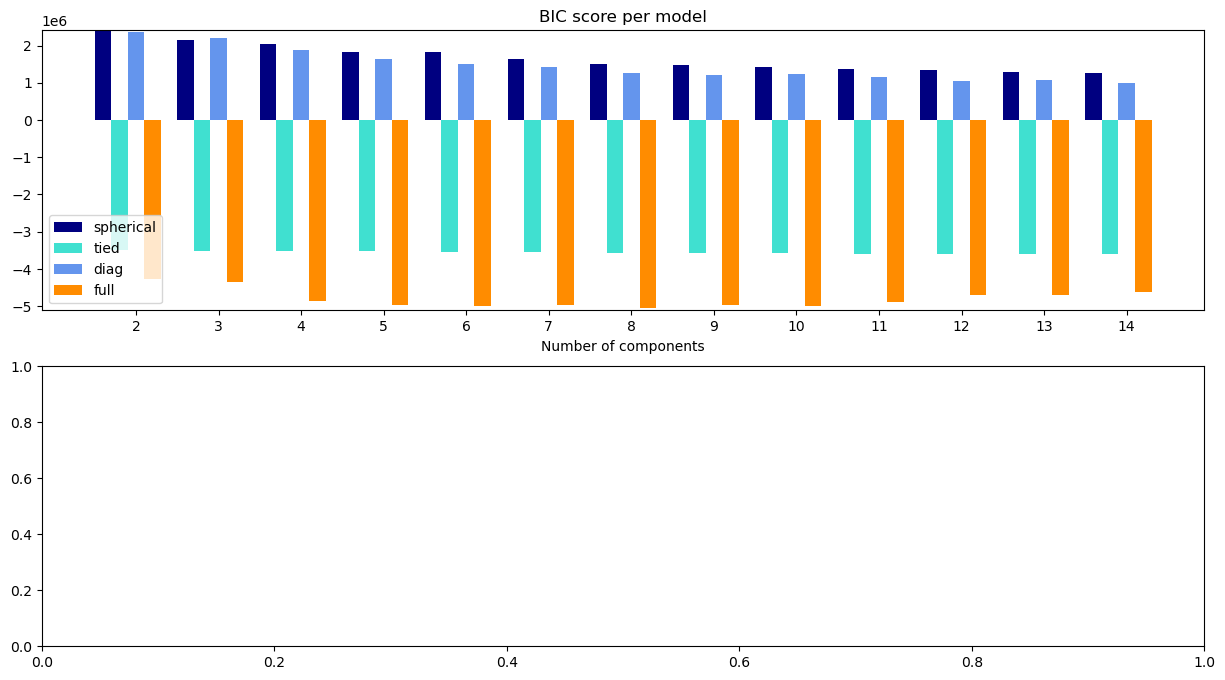

In [3]:
###### Calculate BIC
## This cell compares approaches for covariance - no need to run again, it shows that the approaches result in similar patterns
lowest_bic = np.infty
bic = []
n_components_range = range(2, 15)
cv_types = ["spherical", "tied", "diag", "full"]

for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(
            n_components=n_components, covariance_type=cv_type
        )
        gmm.fit(df)
        bic.append(gmm.bic(df))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(["navy", "turquoise", "cornflowerblue", "darkorange"])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(15, 8))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + 0.2 * (i - 2)
    bars.append(
        plt.bar(
            xpos,
            bic[i * len(n_components_range) : (i + 1) * len(n_components_range)],
            width=0.2,
            color=color,
        )
    )
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - 0.01 * bic.max(), bic.max()])
plt.title("BIC score per model")
xpos = (
    np.mod(bic.argmin(), len(n_components_range))
    + 0.65
    + 0.2 * np.floor(bic.argmin() / len(n_components_range))
)
#plt.text(xpos, bic.min() * 0.97 + 0.03 * bic.max(), "*", fontsize=14)
spl.set_xlabel("Number of components")
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(df)
for i, (meanz, cov, color) in enumerate(zip(clf.means_, clf.covariances_, color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(df.iloc[:,0], df.iloc[:,1], 0.8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ell = mpl.patches.Ellipse(meanz, v[0], v[1], 180.0 + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title(
    f"Selected GMM: {best_gmm.covariance_type} model, "
    f"{best_gmm.n_components} components"
)
plt.subplots_adjust(hspace=0.35, bottom=0.02)
plt.show()


In [ ]:
######### Calculate AIC
lowest_aic = np.infty
aic = []
n_components_range = range(2,15)
cv_types = ["spherical", "tied", "diag", "full"]
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm2 = mixture.GaussianMixture(
            n_components=n_components, covariance_type=cv_type
        )
        gmm2.fit(df)
        aic.append(gmm2.aic(df))
        if aic[-1] < lowest_aic:
            lowest_aic = aic[-1]
            best_gmm_aic = gmm2

aic = np.array(aic)
color_iter = itertools.cycle(["navy", "turquoise", "cornflowerblue", "darkorange"])
clf2 = best_gmm_aic
bars2 = []

# Plot the AIC scores
plt.figure(figsize=(15, 8))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos2 = np.array(n_components_range) + 0.2 * (i - 2)
    bars2.append(
        plt.bar(
            xpos2,
            aic[i * len(n_components_range) : (i + 1) * len(n_components_range)],
            width=0.2,
            color=color,
        )
    )
plt.xticks(n_components_range)
plt.ylim([aic.min() * 1.01 - 0.01 * aic.max(), aic.max()])
plt.title("AIC score per model")
xpos2 = (
    np.mod(aic.argmin(), len(n_components_range))
    + 0.65
    + 0.2 * np.floor(aic.argmin() / len(n_components_range))
)
#plt.text(xpos2, aic.min() * 0.97 + 0.03 * aic.max(), "*", fontsize=14)
spl.set_xlabel("Number of components")
spl.legend([b[0] for b in bars], cv_types)


# Plot the winner
splot2 = plt.subplot(2, 1, 2)
Y_ = clf2.predict(df)
for i, (meand, cov, color) in enumerate(zip(clf2.means_, clf2.covariances_, color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(df.iloc[:,0], df.iloc[:,1], 0.8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ell = mpl.patches.Ellipse(meand, v[0], v[1], 180.0 + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title(
    f"Selected GMM: {best_gmm_aic.covariance_type} model, "
    f"{best_gmm_aic.n_components} components"
)
plt.subplots_adjust(hspace=0.35, bottom=0.02)
plt.show()

In [339]:
#### USE AIC AND BIC TO FIND APPROPRIATE NUMBER OF CLUSTERS
## !!This can take a long time to run!!

# Set up a range of cluster numbers to try
n_range = range(1,50)

# Create empty lists to store the BIC and AIC values
bic_score = []
aic_score = []

# Loop through the range and fit a model
for n in n_range:
    gm = GaussianMixture(n_components=n, covariance_type="full",
                         random_state=30, 
                         n_init=40)
    gm.fit(df)
    #gm.fit(df_new)
    
    # Append the BIC and AIC to the respective lists
    bic_score.append(gm.bic(df))
    aic_score.append(gm.aic(df))
    
# # Plot the BIC and AIC values together
# fig, ax = plt.subplots(figsize=(9,5),nrows=1, dpi=300)
# ax.plot(n_range, bic_score, '-o', color='orange', label='BIC')
# ax.plot(n_range, aic_score, '-o', color='green', label='AIC')
# ax.set(xlabel='Number of Clusters', ylabel='Score')
# ax.set_xticks(n_range)
# ax.set_title('BIC and AIC Scores for Gaussian Mixture Model of full CRB')
# ax.legend()



28 48


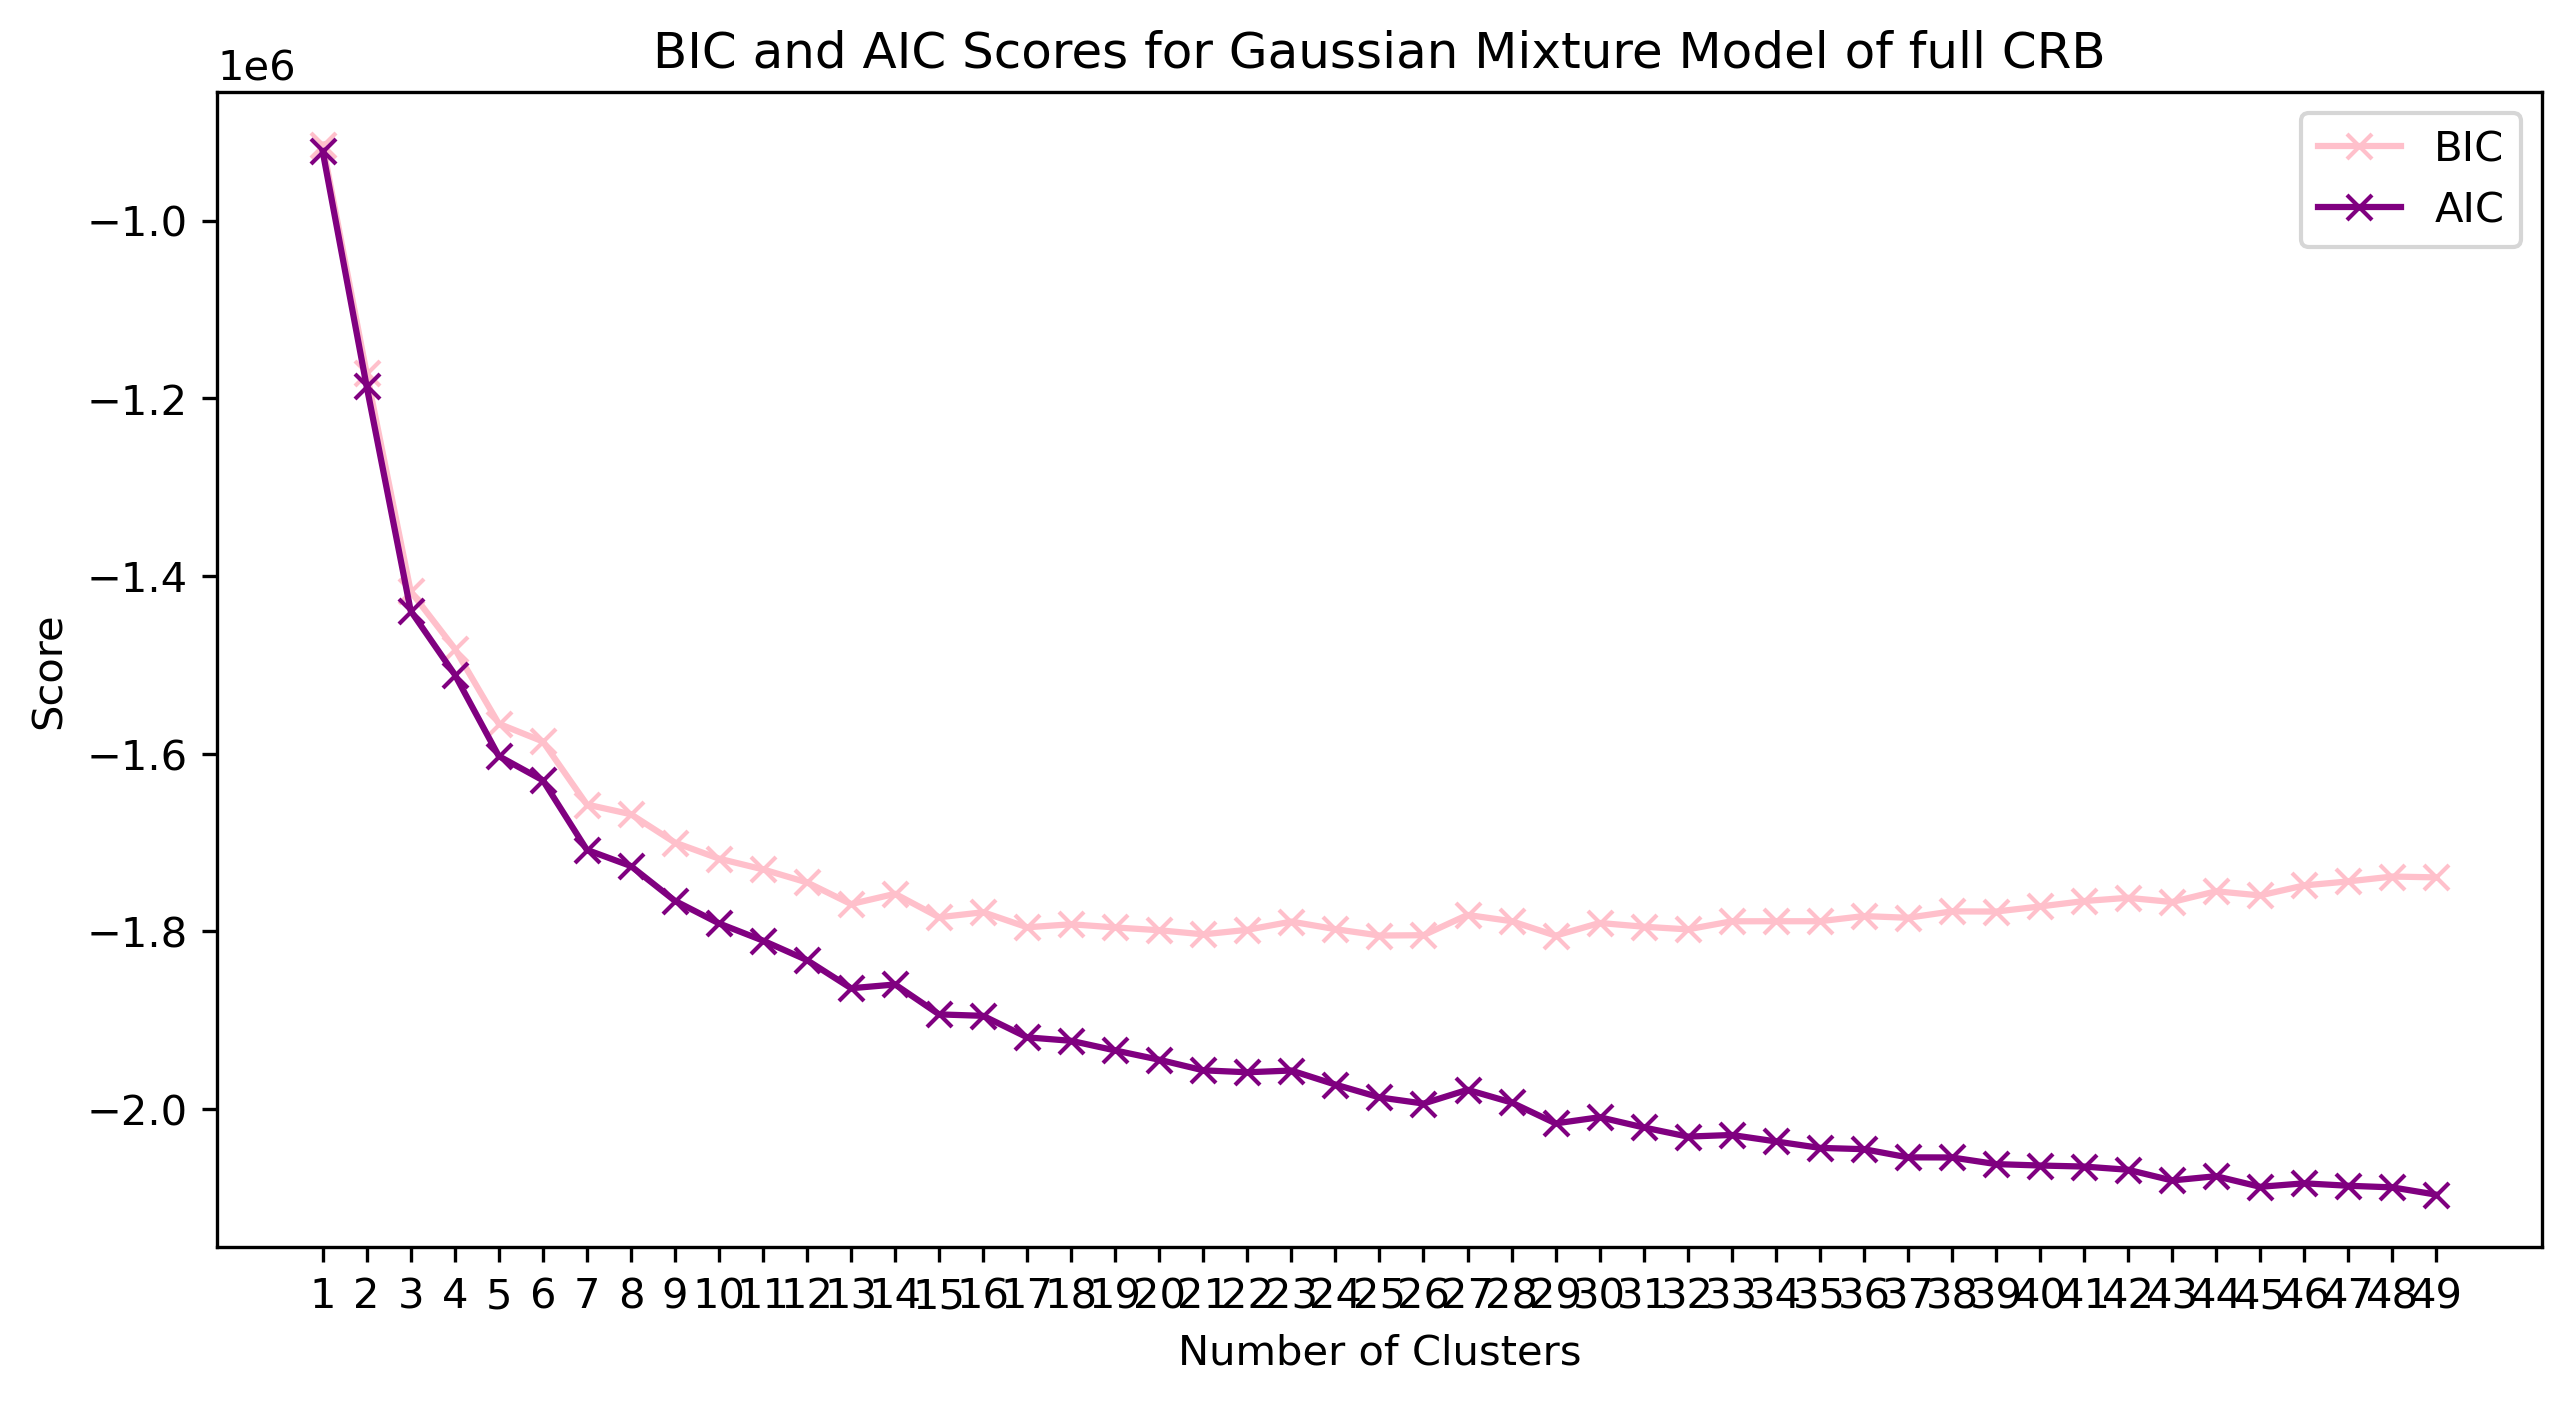

In [340]:
# Plot the BIC and AIC values together
fig, ax = plt.subplots(figsize=(10,5),nrows=1, dpi=300)
ax.plot(n_range, bic_score, '-x', color='pink', label='BIC')
ax.plot(n_range, aic_score, '-x', color='purple', label='AIC')
ax.set(xlabel='Number of Clusters', ylabel='Score')
ax.set_xticks(n_range)
ax.set_title('BIC and AIC Scores for Gaussian Mixture Model of full CRB')
ax.legend()
plt.savefig('AICBIC_majors.pdf')

print(np.argmin(bic_score),np.argmin(aic_score))


In [343]:
n_range = range(18,26)
random_states=15

# Create empty lists to store the BIC and AIC values
bic_score = []
aic_score = []

## Cluster Original Data
HCV_kmeans_orig=[]
HCV_spec_orig=[]
HCV_agg_orig=[]
HCV_mlr_orig=[]

    
###Cluster each data set
SS_kmeans=[]
HCV_kmeans=[]

# Loop through the range and fit a model
for n in n_range:
    for q in range(random_states):
        y_pred = GaussianMixture(n_components=n, covariance_type="full", random_state=q, n_init=30).fit_predict(data_to_use)

        hcv=v_measure_score(labels_to_use ,y_pred)
        HCV_kmeans.append(hcv)
        silhouette_avg = silhouette_score(data_to_use, y_pred)
        SS_kmeans.append(silhouette_avg)

    max_HCV = max(HCV_kmeans)
    max_SS = max(SS_kmeans)
    print('cluster # = ' + str(n))
    print('HCV = ' + str(max_HCV))
    print('SS = ' + str(max_SS))

cluster # = 18
HCV = 0.5251583651018372
SS = 0.24213983980278253
cluster # = 19
HCV = 0.5251583651018372
SS = 0.24213983980278253
cluster # = 20
HCV = 0.5251583651018372
SS = 0.24213983980278253
cluster # = 21
HCV = 0.5251583651018372
SS = 0.24383658819028953
cluster # = 22
HCV = 0.5251583651018372
SS = 0.24383658819028953
cluster # = 23
HCV = 0.5251583651018372
SS = 0.24383658819028953
cluster # = 24
HCV = 0.5254793452052269
SS = 0.24383658819028953
cluster # = 25
HCV = 0.5254793452052269
SS = 0.24383658819028953


## Plot up GMM lables versus actual labels, based on assumed # clusters

In [21]:
################## Gaussian Mixture model

data_to_use=df
labels_to_use=labels
n_cluster = 21 #5 for formation, 21 for member, for max features (one empty cluster here)
random_states=15 #increasing this much beyond 20 makes this VERY slow 

## Cluster Original Data
HCV_kmeans_orig=[]
HCV_spec_orig=[]
HCV_agg_orig=[]
HCV_mlr_orig=[]

    
 ###Cluster each data set
SS_kmeans=[]
HCV_kmeans=[]


max_hcv=[]
        
for q in range(random_states):
    y_pred = GaussianMixture(n_components=n_cluster, covariance_type="full", random_state=q, n_init=30).fit_predict(data_to_use)

#    Metrics for Clustering on W matrix after decomposition
#            silhouette_avg = silhouette_score(df1, y_pred)
#    print(silhouette_avg)
    hcv=v_measure_score(labels_to_use ,y_pred)
#    print(hcv)
#            SS_kmeans.append(silhouette_avg)
            
    HCV_kmeans.append(hcv)
    silhouette_avg = silhouette_score(data_to_use, y_pred)
    SS_kmeans.append(silhouette_avg)
    
max_HCV = max(HCV_kmeans)  # Find the maximum y value
#        max_RS = range(random_states)[HCV_kmeans.argmax()]  # Find the x value corresponding to the maximum y value
#        print (max_HCV, max_RS)
#max_hcv.append(max_HCV)
print(max_HCV)

max_SScore = max(SS_kmeans)
print(max_SScore)

#minerror = min(Errors2)
max_HCV_pos = HCV_kmeans.index(max_HCV)
hcvmax = range(random_states)[max_HCV_pos]


#### Best Fit Number of Clusters and Best Covariance

y_pred_G = GaussianMixture(n_components=n_cluster, covariance_type="full", random_state=hcvmax, n_init=10)
y_pred_g= y_pred_G.fit_predict(data_to_use)


0.7069058717354904
0.23336193267127942


In [356]:
max(HCV_kmeans[90:104])


0.5254793452052269

/Users/leif/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/leif/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


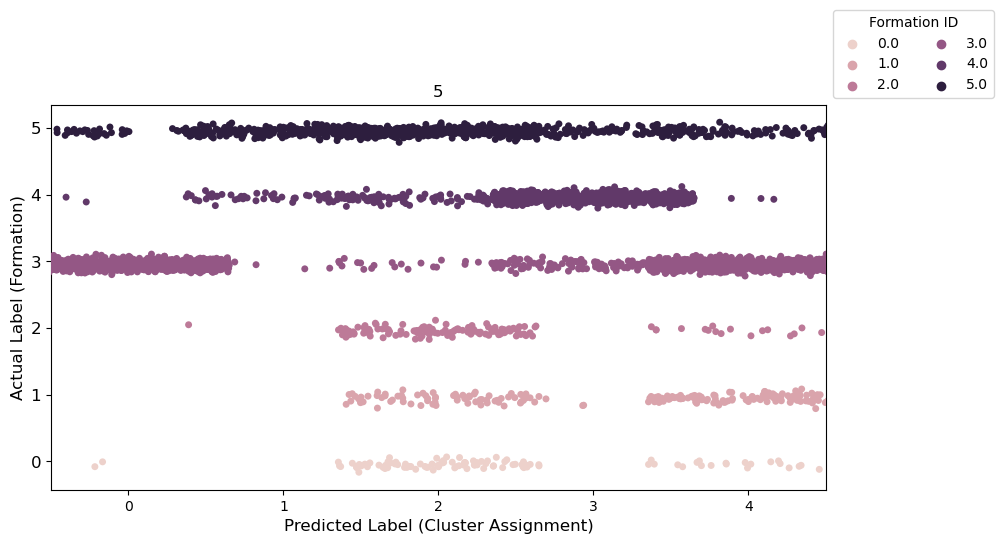

In [282]:
noise = np.random.normal(-.05,.05,np.size(y_pred_g))
plt.figure(figsize=(10,5))

sns.stripplot(x=y_pred_g, y=labels+noise, hue=labels, jitter=.65)
plt.ylabel('Actual Label (Formation)', fontsize=12);
plt.xlabel('Predicted Label (Cluster Assignment)', fontsize=12);
plt.title(n_cluster, fontsize=12)
sns.color_palette()
plt.xticks(fontsize=10)
plt.yticks(fontsize=12)
plt.legend(title='Formation ID', bbox_to_anchor=(1, 1), ncol=2)

## Re-organize and clean up the unsupervised vs supervised plot 

21
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(47, 21) 21
[ 5.  8.  3.  8.  4.  6. 10.  8. 17. 10.  3. 11.  3.  7.  5.  1.  4.  1.
  1.  4.  2.]
[[ 0 18]
 [ 1 16]
 [ 2  7]
 [ 3  3]
 [ 4  4]
 [ 5  8]
 [ 6  0]
 [ 7 15]
 [ 8 17]
 [ 9 20]
 [10  9]
 [11  5]
 [12 14]
 [13  1]
 [14 13]
 [15  6]
 [16 12]
 [17 10]
 [18  2]
 [19 11]
 [20 19]]


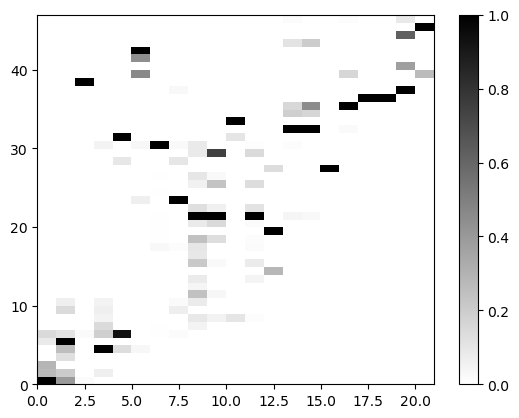

In [22]:
#Nm=np.sum(y_sorted==0)
#plt.hist(x_sorted[0:Nm-1])
UL = y_pred_g#list(ULlabel)
SL = labels#list(SLlabel)

#turn lists into np arrays
ULa=np.asarray(UL)
SLa=np.asarray(SL)

#change this depending on # of labels we decide matter (from AIC/BIC)
NumClust = n_cluster
#this comes from the number of lables in the original data
NumLabel = int(np.amax(labels)+1) #int(np.amax(labels))#
#threshold for what we consider to be a robust correspondence between GMM and original labels
ThreshNum = 2 #10 for formation?


#test case: find all the points in UL with a given label, 
#then count up how many corresponding values in SL this makes
ID0=np.flatnonzero(ULa == 21)
B = np.arange(0,NumClust+1)
#print(B)
#print(len(B))
print(NumClust)

counts = np.zeros(NumLabel)
#print(len(counts))
for j in range(NumLabel):#range(NumClust):
    counts[j] = np.sum(SLa[ID0]==j)
print(counts)    

#now do this over the whole set of UL labels

#ValArray = np.zeros((NumClust+1, NumClust+1))
ValArray = np.zeros((NumLabel, NumClust))

for i in range(NumClust):
    ID=np.flatnonzero(ULa == i)
    counts = np.zeros(NumLabel)#counts = np.zeros(NumClust+1)
    
    for j in range(NumLabel):#NumClust+1):
        if np.sum(SLa[ID]==j)>ThreshNum:
            counts[j] = np.sum(SLa[ID]==j)

    #counts, binEdges=np.histogram(SLa[ID], bins=B)

    #normalize the counts to make columns comparable
    ValArray[:,i]=counts#/np.amax(counts)
    #MaxInd[i] = np.argmax(counts)
    #MaxV[i] = np.amax(counts)   

print(np.shape(ValArray),NumClust)    
#removed any values for which there is not a SL label    
#ValArray[np.isnan(ValArray)] = 0

#now sort the columns of the histogram array in a recursive manner, 
#mergesort keeps the sorting from previous iteration
#https://opensourceoptions.com/blog/sort-numpy-arrays-by-columns-or-rows/
for i in range(NumLabel):
    I = NumLabel - i#NumClust+1 - i
    if i==0:
        Sorted = ValArray[:,(-ValArray[I-1,:]).argsort()]
        
    else:
        Sorted = Sorted[:,(-Sorted[I-1,:]).argsort(kind='mergesort')]
        

        
SortedNorm = Sorted / np.max(Sorted, axis=0)        

#generate binary array of sorted
binary_array = np.zeros(np.shape(Sorted))
binary_array[Sorted != 0] = 1
        
plt.pcolor((SortedNorm),cmap='binary')
plt.colorbar()

#find the indices of columns in original array
ColumnID = geofctns.find_rows(Sorted.T, ValArray.T)

#print(ColumnID) 
#print(Sorted[:,1],ValArray[:,16])
#print(ColumnID[46][1])
print(np.sum(binary_array,axis=0))
print(ColumnID)


In [23]:
#now generate a 'new' UL array that 
#assigns the sorted values to appropriate values in Sorted
SortedUL = np.empty(len(UL))
for i in range(len(ULa)):
    for j in range(NumClust):
        if UL[i]==ColumnID[j,1]:
            SortedUL[i]=ColumnID[j,0]
        # if UL[i]==ColumnID[j][1]:
        #     SortedUL[i]=ColumnID[j][0]
    
  

47 47


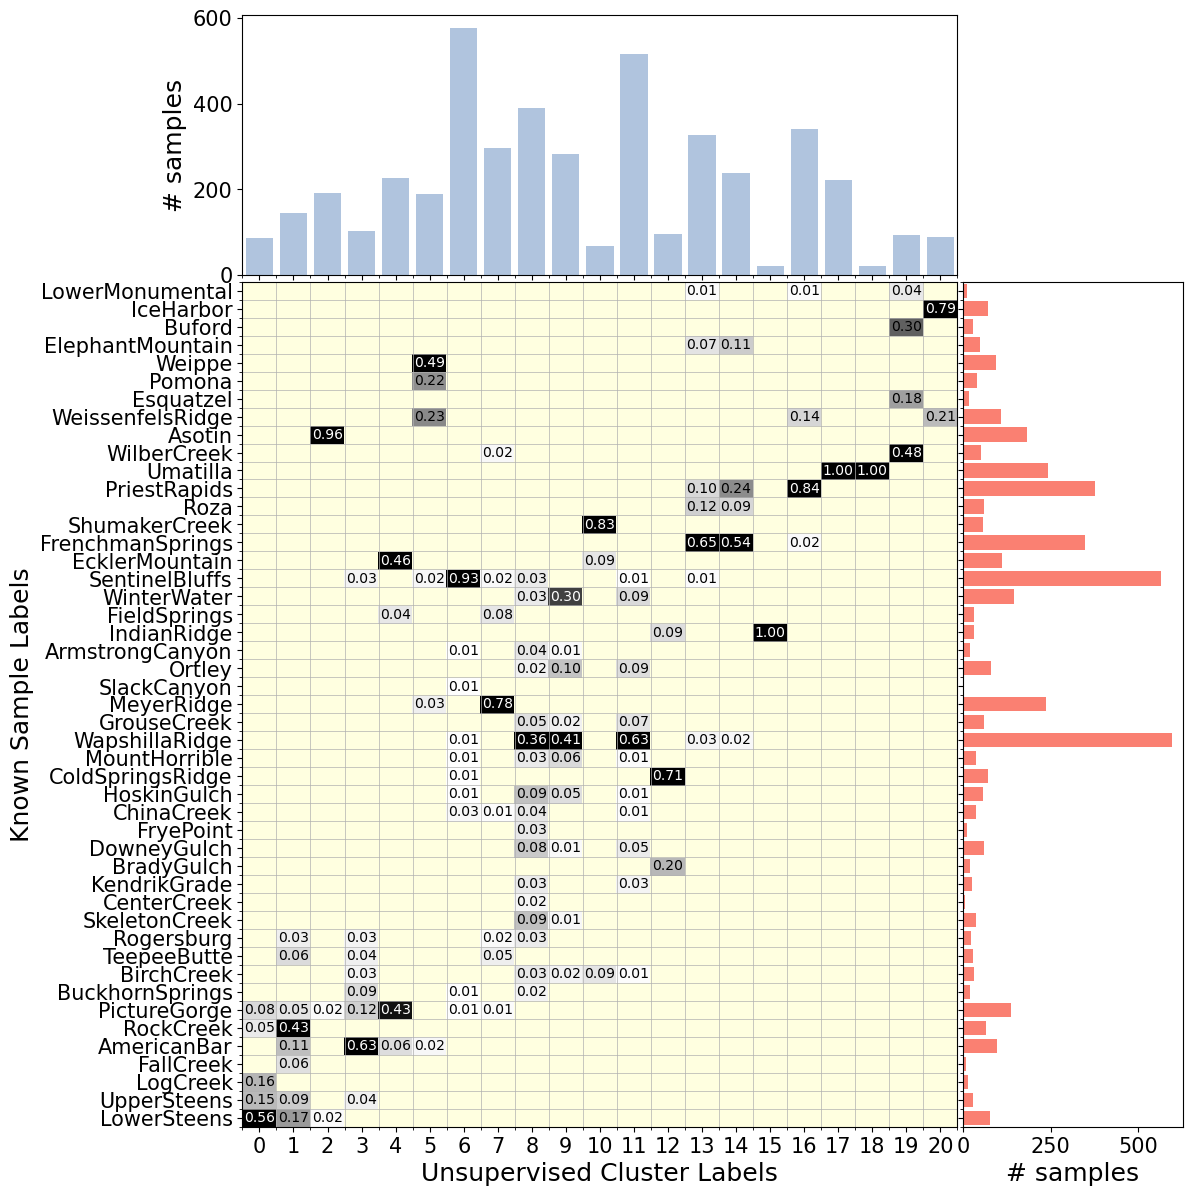

In [44]:
#importlib.reload(geoplots)
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

print((NumLabel),np.size(list(LookupTable.Member)))

nbins=n_cluster#22

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(11, 13))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

#manually sort to get the columns where we want them 

# order = [3,15,1,10,19,0,20,13,18,7,14,12,2,6,16,5,11,17,9,4,8]
# ORD = np.array(order)
# sorted_indices = np.argsort([0,2,1,6,13,9,10,12,7,8,4,14,15,11,17,18,19,20,5,16,3 ])
# order2 = ORD[[0,2,1,6,13,9,10,12,7,8,4,14,15,11,17,18,19,20,5,16,3 ]]

MemberOrd = [0,5,8,3,13,6,1,7,12,17,19,16,15,18,4,2,11,9,20,10,14]#[4,1,0,2,3]#

#Sorted2 = Sorted[:,[0,2,1,6,13,9,10,12,7,8,4,14,15,11,17,18,19,20,5,16,3 ]] #this one is for maximize samples
#Sorted3 = Sorted[:,[0,4,1,6,3,11,12,9,8,14,7,13,16,10,17,18,19,2,5,20 ]]

#Sorted[:,[0,2,1,3,10,5,6,7,9,12,11,4,13,15,16,17,18,19,20,14,22,21]] #23 clusters
#Sorted[:,[0,1,3,2,4,5]] #formation, 6 clusters

# use the previously defined function ValArray[:,order2]#[:,[4,1,0,2,3]]
geoplots.pcolor_hist(ValArray[:,ColumnID[:,1]], ax, ax_histx, ax_histy,nbins,list(LookupTable.Member))
#this is what was used for paper
#ValArray[:,MemberOrd]
#geoplots.scatter_hist(SortedUL, SL, ax, ax_histx, ax_histy,nbins,list(LookupTable.Member))

plt.show()

#fig.savefig('CRB_GMM_MemberCompare.pdf')

In [43]:
ColumnID[:,1]

array([18, 16,  7,  3,  4,  8,  0, 15, 17, 20,  9,  5, 14,  1, 13,  6, 12,
       10,  2, 11, 19])

In [12]:
list(LookupTable.Member)

['LowerSteens',
 'UpperSteens',
 'LogCreek',
 'FallCreek',
 'AmericanBar',
 'RockCreek',
 'PictureGorge',
 'BuckhornSprings',
 'BirchCreek',
 'TeepeeButte',
 'Rogersburg',
 'SkeletonCreek',
 'CenterCreek',
 'KendrikGrade',
 'BradyGulch',
 'DowneyGulch',
 'FryePoint',
 'ChinaCreek',
 'HoskinGulch',
 'ColdSpringsRidge',
 'MountHorrible',
 'WapshillaRidge',
 'GrouseCreek',
 'MeyerRidge',
 'SlackCanyon',
 'Ortley',
 'ArmstrongCanyon',
 'IndianRidge',
 'FieldSprings',
 'WinterWater',
 'SentinelBluffs',
 'EcklerMountain',
 'FrenchmanSprings',
 'ShumakerCreek',
 'Roza',
 'PriestRapids',
 'Umatilla',
 'WilberCreek',
 'Asotin',
 'WeissenfelsRidge',
 'Esquatzel',
 'Pomona',
 'Weippe',
 'ElephantMountain',
 'Buford',
 'IceHarbor',
 'LowerMonumental']

In [285]:
indices = [i for i, x in enumerate(y_pred_g) if x ==19]
#print(indices)

In [401]:
binary_array = np.zeros(np.shape(SortedNorm))
binary_array[SortedNorm != 0] = 1
binary_array
x = np.sum(ValArray,axis=0)
x

array([254., 345., 499., 572., 243., 321., 250., 295., 218., 245., 117.,
       323., 144., 292., 100.,  91., 198.,   0.])

(6, 210)

In [50]:
# Save the GMM model using pickle
filename = 'gmm_model_21clusters_maxFeatures.pkl'
with open(filename, 'wb') as file:
    pickle.dump(y_pred_G, file)

print(f"GMM model saved to {filename}")

filename = 'gmm_model_21clusters_maxFeatures_dfPredicted.pkl'
with open(filename, 'wb') as file:
    pickle.dump(y_pred_g, file)

# # Load the GMM model using pickle
# with open(filename, 'rb') as file:
#     loaded_gmm = pickle.load(file)

# # Use the loaded model for predictions or other tasks
# labels = loaded_gmm.predict(X)
# print("Predictions:", labels)

GMM model saved to gmm_model_21clusters_maxFeatures.pkl


In [250]:
LookupTable.Member

0          LowerSteens
1          UpperSteens
2             LogCreek
3            FallCreek
4          AmericanBar
5            RockCreek
6         PictureGorge
7      BuckhornSprings
8           BirchCreek
9          TeepeeButte
10          Rogersburg
11       SkeletonCreek
12         CenterCreek
13        KendrikGrade
14          BradyGulch
15         DowneyGulch
16           FryePoint
17          ChinaCreek
18         HoskinGulch
19    ColdSpringsRidge
20       MountHorrible
21      WapshillaRidge
22         GrouseCreek
23          MeyerRidge
24         SlackCanyon
25              Ortley
26     ArmstrongCanyon
27         IndianRidge
28        FieldSprings
29         WinterWater
30      SentinelBluffs
31      EcklerMountain
32    FrenchmanSprings
33       ShumakerCreek
34                Roza
35        PriestRapids
36            Umatilla
37         WilberCreek
38              Asotin
39    WeissenfelsRidge
40           Esquatzel
41              Pomona
42              Weippe
43    Eleph

In [411]:
print(len(y_pred_G.feature_names_in_))
y_pred_G.feature_names_in_


210


array(['SiO2', 'TiO2', 'Al2O3', 'MnO', 'MgO', 'CaO', 'Na2O', 'K2O',
       'P2O5', 'Ni', 'Cr', 'Sc', 'V', 'Ba', 'Rb', 'Sr', 'Zr', 'Y', 'Nb',
       'Cu', 'TiO2/SiO2', 'Al2O3/SiO2', 'MnO/SiO2', 'MgO/SiO2',
       'CaO/SiO2', 'Na2O/SiO2', 'K2O/SiO2', 'P2O5/SiO2', 'Ni/SiO2',
       'Cr/SiO2', 'Sc/SiO2', 'V/SiO2', 'Ba/SiO2', 'Rb/SiO2', 'Sr/SiO2',
       'Zr/SiO2', 'Y/SiO2', 'Nb/SiO2', 'Cu/SiO2', 'Al2O3/TiO2',
       'MnO/TiO2', 'MgO/TiO2', 'CaO/TiO2', 'Na2O/TiO2', 'K2O/TiO2',
       'P2O5/TiO2', 'Ni/TiO2', 'Cr/TiO2', 'Sc/TiO2', 'V/TiO2', 'Ba/TiO2',
       'Rb/TiO2', 'Sr/TiO2', 'Zr/TiO2', 'Y/TiO2', 'Nb/TiO2', 'Cu/TiO2',
       'MnO/Al2O3', 'MgO/Al2O3', 'CaO/Al2O3', 'Na2O/Al2O3', 'K2O/Al2O3',
       'P2O5/Al2O3', 'Ni/Al2O3', 'Cr/Al2O3', 'Sc/Al2O3', 'V/Al2O3',
       'Ba/Al2O3', 'Rb/Al2O3', 'Sr/Al2O3', 'Zr/Al2O3', 'Y/Al2O3',
       'Nb/Al2O3', 'Cu/Al2O3', 'MgO/MnO', 'CaO/MnO', 'Na2O/MnO',
       'K2O/MnO', 'P2O5/MnO', 'Ni/MnO', 'Cr/MnO', 'Sc/MnO', 'V/MnO',
       'Ba/MnO', 'Rb/MnO', 'Sr/MnO',

/Users/leif/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


Zr/Ba Zr/P2O5
MgO Ni
Rb Cr
Nb/Zr SiO2
[49.06676495 50.46414345 50.33       52.035      51.24999794 51.39
 53.843      53.72       54.93       55.6        54.775      55.38500054
 54.990002   50.81613922 51.47       52.795      50.195      54.12
 57.085      54.16       48.46      ]


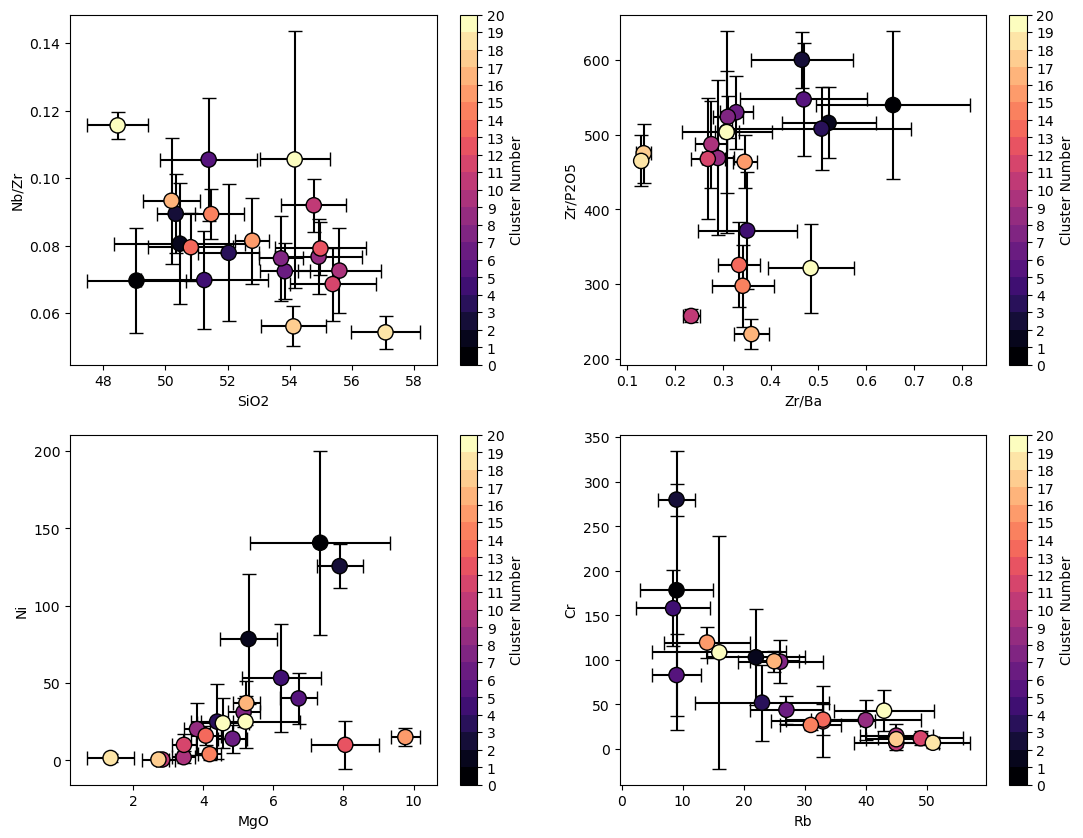

In [49]:
import matplotlib.cm as cm
import matplotlib.ticker as ticker
from scipy import stats

#
#define cluster ordering to match the matrix figures
order2=[0,5,8,3,13,6,1,7,12,17,19,16,15,18,4,2,11,9,20,10]#[0,5,8,3,13,6,1,7,12,17,19,16,15,18,4,2,11,9,20,10] #[4,1,0,2,3]


order2=ColumnID[:,1]

y_pred_Go = y_pred_G#pd.DataFrame(power_transformer.inverse_transform(y_pred_G), columns=df.columns)

lambdas = power_transformer.lambdas_
#print(f"Lambda values: {lambdas}")  # Lambda for each feature

#do the inverse power transorm to get original values 
# Means = power_transformer.inverse_transform(y_pred_Go.means_)
# Cov =  y_pred_Go.covariances_
Means = power_transformer.inverse_transform(y_pred_Go.means_[order2,:])
#Means = (y_pred_Go.means_[order2,:])

Cov =  y_pred_Go.covariances_[order2,:,:]

ElNum = {}

# #5 clusters
# ElNum["N1"] = 13
# ElNum["N2"] = 16
# ElNum["N3"] = 4
# ElNum["N4"] = 9
# ElNum["N5"] = 14
# ElNum["N6"] = 10
# ElNum["N7"] = 6
# ElNum["N8"] = 0
# ElNum["N9"] = 7

#20 clusters for main text
ElNum["N1"] = 191
ElNum["N2"] = 151
ElNum["N3"] = 4
ElNum["N4"] = 9
ElNum["N5"] = 14
ElNum["N6"] = 10
ElNum["N7"] = 205
ElNum["N8"] = 0
ElNum["N9"] = 7

#20 clusters for supplement
# ElNum["N1"] = 1
# ElNum["N2"] = 10
# ElNum["N3"] = 13
# ElNum["N4"] = 15
# ElNum["N5"] = 0#53
# ElNum["N6"] = 7#165
# ElNum["N7"] = 8
# ElNum["N8"] = 1



#member
# ElNum1 = 191#7#16#186#191#13
# ElNum2 =151#10#18#184#10

# ElNum3 = 4
# ElNum4 = 9

# ElNum5 = 14#193
# ElNum6 = 10#171

# ElNum7 = 205#53
# ElNum8 = 0#184


print(y_pred_Go.feature_names_in_[ElNum["N1"]],y_pred_Go.feature_names_in_[ElNum["N2"]])
print(y_pred_Go.feature_names_in_[ElNum["N3"]],y_pred_Go.feature_names_in_[ElNum["N4"]])
print(y_pred_Go.feature_names_in_[ElNum["N5"]],y_pred_Go.feature_names_in_[ElNum["N6"]])
print(y_pred_Go.feature_names_in_[ElNum["N7"]],y_pred_Go.feature_names_in_[ElNum["N8"]])

# El1m = Means[:,ElNum["N1"]]
# El2m = Means[:,ElNum["N2"]]
# El3m = Means[:,ElNum["N3"]]
# El4m = Means[:,ElNum["N4"]]
# El5m = Means[:,ElNum["N5"]]
# El6m = Means[:,ElNum["N6"]]
# El7m = Means[:,ElNum["N7"]]+Means[:,ElNum["N9"]]
# El8m = Means[:,ElNum["N8"]]


size = 20 #5

# #for member
# IQR=np.empty([size+1,8])
# Mean=np.empty([size+1,8])
# Median=np.empty([size+1,8])
# # Get indices for each cluster
# clustered_indices = [np.where(y_pred_g == i)[0] for i in range(size+1)]

#for member
IQR=np.empty([size+1,8])
Mean=np.empty([size+1,8])
Median=np.empty([size+1,8])
# Get indices for each cluster
clustered_indices = [np.where(y_pred_g == i)[0] for i in range(size+1)]

#for formation
# IQR=np.empty([size,8])
# Mean=np.empty([size,8])
# Median=np.empty([size,8])
# # Get indices for each cluster
# clustered_indices = [np.where(y_pred_g == i)[0] for i in range(size)]

for j in range(8):
    #NM = y_pred_Go.feature_names_in_[ElNum["N"+str(j+1)]]
    for i, indices in enumerate(clustered_indices):
        DF=power_transformer.inverse_transform(df.iloc[indices])
        #DF=np.asarray(df.iloc[indices])
        IQR[i,j]=(stats.iqr(DF[:,ElNum["N"+str(j+1)]]))
        Mean[i,j]=(np.mean(DF[:,ElNum["N"+str(j+1)]]))
        Median[i,j]=(np.median(DF[:,ElNum["N"+str(j+1)]]))
        # if i==6:
        #     IQR[i,j]=(stats.iqr(DF[:,ElNum["N"+str(7)]]+ DF[:,ElNum["N"+str(9)]]))
        #     Mean[i,j]=(np.mean(DF[:,ElNum["N"+str(7)]]+ DF[:,ElNum["N"+str(9)]]))
        #     Median[i,j]=(np.median(DF[:,ElNum["N"+str(7)]]+ DF[:,ElNum["N"+str(9)]]))

print(Median[order2,7])
# Colormap instance
#cmap = cm.get_cmap('tab20b',21)

cmap = plt.get_cmap("magma", size)
#cmap = plt.get_cmap("magma", 21)

fig, axs = plt.subplots(2,2,figsize=(13,10))
axs[0,0].errorbar(Median[order2,7],Median[order2,6],xerr=IQR[order2,7],yerr=IQR[order2,6],fmt='none',capsize=5,ecolor='black',zorder=1)
#axs[0,0].errorbar(El8m,El7m,xerr=IQR[:,7],yerr=IQR[:,6],fmt='none',capsize=5,ecolor='black',zorder=1)
#axs[0,0].errorbar(El8m,El7m,xerr=El8std,yerr=El7std,fmt='none',capsize=5,ecolor='black',zorder=1)
scatter=axs[0,0].scatter(Median[order2,7],Median[order2,6], c=np.arange(size+1),cmap=cmap, marker='o', s=120,zorder=2,edgecolor='black')
#scatter=axs[0,0].scatter(El8m,El7m, c=np.arange(size),cmap=cmap, marker='o', s=120,zorder=2,edgecolor='black')
axs[0,0].set_ylabel(y_pred_G.feature_names_in_[ElNum["N7"]])#'Na2O + K2O')#
axs[0,0].set_xlabel(y_pred_G.feature_names_in_[ElNum["N8"]])
#axs[0,0].set_xlim([0,4])
#axs[0,0].set_xscale('log')
cbar = fig.colorbar(scatter)
cbar.set_label('Cluster Number')
# Set the number of ticks using MaxNLocator (e.g., to a maximum of 5 ticks)
cbar.locator = ticker.MaxNLocator(nbins=size)
cbar.update_ticks()

axs[0,1].errorbar(Median[order2,0],Median[order2,1],yerr=IQR[order2,1],xerr=IQR[order2,0],fmt='none',capsize=5,ecolor='black',zorder=1)
#axs[0,1].errorbar(El1m,El2m,yerr=IQR[:,1],xerr=IQR[:,0],fmt='none',capsize=5,ecolor='black',zorder=1)
#scatter=axs[0,1].scatter(El1m,El2m, c=np.arange(size),cmap=cmap, marker='o', s=120,zorder=2,edgecolor='black')
scatter=axs[0,1].scatter(Median[order2,0],Median[order2,1], c=np.arange(size+1),cmap=cmap, marker='o', s=120,zorder=2,edgecolor='black')
axs[0,1].set_ylabel(y_pred_G.feature_names_in_[ElNum["N2"]])
axs[0,1].set_xlabel(y_pred_G.feature_names_in_[ElNum["N1"]])
cbar = fig.colorbar(scatter)
cbar.set_label('Cluster Number')
cbar.locator = ticker.MaxNLocator(nbins=size)
cbar.update_ticks()
#axs[0,1].set_ylim([0.15,1.15])
#axs[0,1].set_xlim([0.15,0.28])

axs[1,0].errorbar(Median[order2,2],Median[order2,3],yerr=IQR[order2,3],xerr=IQR[order2,2],fmt='none',capsize=5,ecolor='black',zorder=1)
scatter=axs[1,0].scatter(Median[order2,2],Median[order2,3], c=np.arange(size+1),cmap=cmap, marker='o', s=120,zorder=2,edgecolor='black')
#axs[1,0].errorbar(El3m,El4m,yerr=IQR[:,3],xerr=IQR[:,2],fmt='none',capsize=5,ecolor='black',zorder=1)
#scatter=axs[1,0].scatter(El3m,El4m, c=np.arange(size),cmap=cmap, marker='o', s=120,zorder=2,edgecolor='black')
axs[1,0].set_ylabel(y_pred_G.feature_names_in_[ElNum["N4"]])
axs[1,0].set_xlabel(y_pred_G.feature_names_in_[ElNum["N3"]])
#axs[1,0].set_xscale('log')
cbar = fig.colorbar(scatter)
cbar.set_label('Cluster Number')
cbar.locator = ticker.MaxNLocator(nbins=size)
cbar.update_ticks()

axs[1,1].errorbar(Median[order2,4],Median[order2,5],yerr=IQR[order2,5],xerr=IQR[order2,4],fmt='none',capsize=5,ecolor='black',zorder=1)
scatter=axs[1,1].scatter(Median[order2,4],Median[order2,5], c=np.arange(size+1),cmap=cmap, marker='o', s=120,zorder=2,edgecolor='black')
#axs[1,1].errorbar(El5m,El6m,yerr=IQR[:,5],xerr=IQR[:,4],fmt='none',capsize=5,ecolor='black',zorder=1)
#scatter=axs[1,1].scatter(El5m,El6m, c=np.arange(size),cmap=cmap, marker='o', s=120,zorder=2,edgecolor='black')
axs[1,1].set_ylabel(y_pred_G.feature_names_in_[ElNum["N6"]])
axs[1,1].set_xlabel(y_pred_G.feature_names_in_[ElNum["N5"]])

cbar = fig.colorbar(scatter)
cbar.set_label('Cluster Number')
cbar.locator = ticker.MaxNLocator(nbins=size)
cbar.update_ticks()

#plt.savefig('GMMMeans_Member_Supp.pdf')

ValueError: x and y must have same first dimension, but have shapes (20,) and (21,)

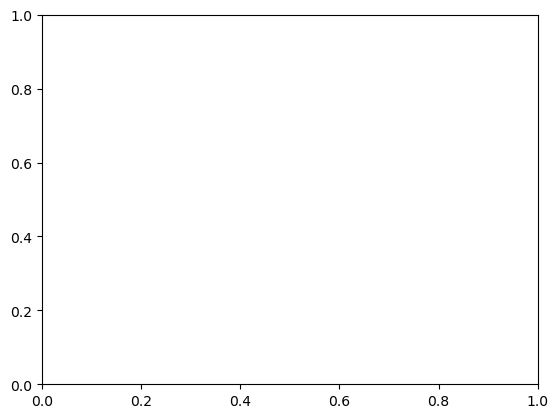

In [27]:
plt.plot(Median[order2,4],np.arange(21),'o-')
#plt.plot(El6m,np.arange(20),'o-')

In [51]:
ColumnID[:,1]

array([18, 16,  7,  3,  4,  8,  0, 15, 17, 20,  9,  5, 14,  1, 13,  6, 12,
       10,  2, 11, 19])

In [659]:
Means[:,ElNum["N2"]]

array([89.93965073, 48.44163195, 26.5238358 , 20.5978607 ,  5.37348062])

In [720]:
print(y_pred_Go.means_[0,0])
Mipt = power_transformer.inverse_transform(y_pred_Go.means_)
print(Mipt[0,0],lambdas[0])
pwr=(1 / lambdas[0])
(y_pred_Go.means_[0,0] * lambdas[0] + 1) 

-0.7916990221259481
51.12769064991745 3.159397678305583


/Users/leif/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


-1.5012920524215208

In [761]:
# Get indices for each cluster
clustered_indices = [np.where(y_pred_g == i)[0] for i in range(5)]

# Print the results
NM = y_pred_Go.feature_names_in_[ElNum["N2"]]
print(NM)
VL=np.empty(5)
for i, indices in enumerate(clustered_indices):
    DF=power_transformer.inverse_transform(df.iloc[indices])
    VL[i]=(stats.iqr(DF[:,ElNum["N2"]]))

        

Cu


In [762]:
VL

array([18. , 37.5, 18. ,  7. , 62. ])